In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df   

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df.drop(columns="total_CPM", inplace=True)
    
    return merged_df

In [5]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:
        
        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split("source_transcript=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get CHM gene_ids
        df["CHM_gene_id"] = df["other"].str.split("gene_id=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["CHM_transcript_id"] = df["other"].str.split("transcript_id=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get transcript names
        df["transcript_name"] = df["other"].str.split("source_transcript_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get start codon
        df["start_codon"] = df["other"].str.split("adj_start=", expand=True)[1].str.split(";", expand=True)[0]
        
        ## Get stop codon
        df["stop_codon"] = df["other"].str.split("adj_stop=", expand=True)[1].str.split(";", expand=True)[0]        

        ## Only keep relevant
        df = df[["chr", "start", "end", "strand", "type", "gene_id", "transcript_id", "CHM_gene_id",
                 "CHM_transcript_id", "transcript_name", "gene_name", "start_codon", "stop_codon"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        
        #df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]


        ## Get CHM transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Label novel transcripts
        #df.loc[df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
        #df.loc[~df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

        ## Label novel genes
        #df.loc[df["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
        #df.loc[~df["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [6]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

In [7]:
'''
function name: merge_annotations

purpose: Merge useful/relevant information from both annotations while removing repeated and irrelevant information

input: Two different GTF annotations

output: One GTF annotation containing all the relevant information
'''

def merge_annotations(ref_gtf, bambu_gtf):
    
    ## Merge the two annotations
    names_ref_gtf = ref_gtf[["transcript_id", "gene_id", "gene_name", "transcript_name"]].copy()
    merged_gtf = pd.merge(bambu_gtf, names_ref_gtf, on=['gene_id', 'transcript_id'], how='left')
    merged_gtf.drop_duplicates(inplace=True)

    ## Label novel transcripts
    merged_gtf.loc[merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
    merged_gtf.loc[~merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

    ## Label novel genes
    merged_gtf.loc[merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
    merged_gtf.loc[~merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

    ## Create temporary variable only containing novel transcripts
    temp = merged_gtf.loc[merged_gtf["is_novel_transcript"] == True]

    ## Annotate novel transcripts
    merged_tmp = pd.merge(temp, ref_gtf[["gene_id", "gene_name"]], on=['gene_id'], how='left')
    merged_tmp.drop_duplicates(inplace=True)
    merged_tmp["gene_name"] = merged_tmp["gene_name_y"]
    merged_tmp.drop(columns=["source", "gene_name_y", "gene_name_x"], inplace=True)

    ## Return novel transcripts to original annotation
    merged_final = pd.merge(merged_gtf, merged_tmp, on=['chr', 'type', 'start', 'end', 'strand', 'transcript_id',
                    'transcript_name', 'gene_id', 'is_novel_transcript', 'is_novel_gene', 'exon_number'], how="left")

    ## Get gene names for novel transcripts of known genes
    merged_final.gene_name_x.fillna(merged_final.gene_name_y, inplace=True)
    merged_final["gene_name"] = merged_final["gene_name_x"]
    merged_final.drop(columns =["gene_name_x", "gene_name_y"], inplace=True)
    
    ## Get start and stop codons for known transcripts and exons of protein coding genes
    ref_gtf = ref_gtf[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "start_codon", "stop_codon"]]
    merged_final = pd.merge(merged_final, ref_gtf, on=["chr", "type", "start", "end", "strand", "transcript_id", "gene_id"], how="left")
    
    
    merged_final = merged_final[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "gene_name", 
                    "exon_number", "transcript_name", "start_codon", "stop_codon", "is_novel_gene", "is_novel_transcript"]]


    
    return merged_final 

In [8]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

## 1) Stringent CHM13 Discovery Analysis - Wordcloud and exon histograms

In [30]:
## Fix column names in counts matrix

chm13_counts = pd.read_csv("../../data/raw/CHM13_merged_aged_stringent/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

chm13_counts = fix_column_names(chm13_counts, is_gene=False)

In [31]:
## Calculate total counts and fix gene id
chm13_counts["total_counts"] = chm13_counts[chm13_counts.columns[2:6].tolist()].sum(axis=1)

In [32]:
## Calculate CPM and drop count columns
chm13_counts = calculate_cpm(chm13_counts, is_gene=False)

chm13_counts = chm13_counts[chm13_counts.columns.drop(list(chm13_counts.filter(regex='counts')))]

In [33]:
## Find novel transcripts in both annotations
chm13_counts.loc[chm13_counts["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
chm13_counts.loc[~chm13_counts["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

## Find novel genes in both annotations
chm13_counts.loc[chm13_counts["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
chm13_counts.loc[~chm13_counts["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

In [34]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
chm13_novel_genes = chm13_counts.loc[chm13_counts["is_novel_gene"]].copy()
chm13_novel_transcripts = chm13_counts.loc[((chm13_counts["is_novel_transcript"]) & (~chm13_counts["is_novel_gene"]))].copy()

In [35]:
## See how many novel genes
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13")
print("We found", chm13_novel_transcripts.shape[0], "novel transcripts in CHM13")

We found 170 novel genes in CHM13
We found 546 novel transcripts in CHM13


In [36]:
## Filter novel genes and transcripts, total CPM > 1
chm13_novel_genes = chm13_novel_genes[(chm13_novel_genes["total_CPM"]>1)]
chm13_novel_transcripts = chm13_novel_transcripts[(chm13_novel_transcripts["total_CPM"]>1)]

In [37]:
## Count number of novel genes and novel transcripts in each dataframe
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13 (avg CPM > 1)")
print("We found", chm13_novel_transcripts.shape[0], "novel transcripts of known genes in CHM13 (avg CPM > 1)")

We found 81 novel genes in CHM13 (avg CPM > 1)
We found 458 novel transcripts of known genes in CHM13 (avg CPM > 1)


In [38]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
chm13_ref = pd.read_csv("../../data/raw/CHM13_merged_aged_stringent/bambu_discovery/extended_annotations.gtf",
                        header=None, delimiter="\t", low_memory=False, 
                        names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


chm13_ref = parse_df_columns(chm13_ref, is_ref=False)

In [39]:
## Define annotation with new genes only
chm13_ref_new_gene = chm13_ref.loc[chm13_ref["gene_id"].isin(chm13_novel_genes["gene_id"])].copy()

In [40]:
## Only keep transcripts
chm13_ref = chm13_ref.loc[chm13_ref["type"] == "transcript"].copy()

In [41]:
## Only keep expressed transcripts
chm13_novel_transcripts_expressed = chm13_ref.loc[chm13_ref["transcript_id"].isin(
                                                    chm13_novel_transcripts["transcript_id"])].copy()

In [42]:
chm13_novel_transcripts_expressed.shape

(458, 9)

In [43]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
orig_ref = pd.read_csv("../../references/CHM13.v2.0.gff3", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

In [23]:
## Create good reference to convert gene names
orig_ref = orig_ref.loc[orig_ref["type"]=="transcript"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

In [24]:
orig_ref = make_gene_and_transcript_converter(orig_ref)

In [25]:
orig_ref_filtered = orig_ref[["gene_id", "gene_name"]]

In [26]:
novel_relevant = chm13_novel_transcripts_expressed.merge(orig_ref_filtered, on=["gene_id"], how="inner")

In [27]:
novel_relevant.drop_duplicates(inplace=True)

In [28]:
novel_relevant.shape

(458, 10)

In [29]:
novel_relevant = novel_relevant.loc[novel_relevant["chr"] != "chrM"].copy()

In [30]:
list_new_transcript_genes = ['ALDH1A1','B4GALT7', 'BCAN', 'CA5A', 'CAMKMT', 'CAST', 'CD4', 'CLIC2', 'CPLX2', 'CRBN', 'DGUOK',
 'DPYD', 'DPYS', 'FGF9', 'IVD', 'KHK', 'KIF27', 'LRP4', 'MAOB', 'MAP2K4', 'MFF', 'NDUFV3', 'NELFA', 'NME5', 'PBRM1', 'PKM',
 'POLB', 'PPP6C', 'PSENEN', 'RAB27B', 'ROM1', 'SLC26A1', 'SMS', 'SNTG2', 'TBCE', 'TET1', 'TSFM', 'XPNPEP3', 'ZNF429']

In [31]:
novel_relevant = novel_relevant.loc[novel_relevant['gene_name'].isin(list_new_transcript_genes)].copy()

In [32]:
## Merge with medically relevant genes on gene_id and get gene names
novel_relevant_counts = pd.merge(chm13_counts, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [33]:
## Drop any duplicates
novel_relevant_counts.drop_duplicates(inplace=True)

In [34]:
## See shape
novel_relevant_counts.shape

(355, 10)

In [35]:
## See number of novel transcript left
novel_relevant_counts.loc[novel_relevant_counts["is_novel_transcript"]==True].shape

(29, 10)

In [36]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)

In [37]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"] == True][["gene_name", "relative_abundance_percent"]]

In [38]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()

In [39]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [40]:
## Create a dataframe to properly store the data
novel_relevant_word_df = pd.DataFrame()
novel_relevant_word_df['word_count'] = novel_relevant_words
novel_relevant_word_df["gene_name"] = novel_relevant_words.index

In [41]:
## Drop index
novel_relevant_word_df.reset_index(inplace=True, drop=True)

In [42]:
## Print genes with novel isoforms relevant to AD
ad_names = pd.read_csv("../../references/AD_genes.csv", sep="\t")
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(ad_names["gene_name"])])

Empty DataFrame
Columns: [word_count, gene_name]
Index: []


In [43]:
## Print relative abundance for a couple other genes
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(["MAOB", "SLC26A1"])])

    word_count gene_name
15         9.0      MAOB
23        90.0   SLC26A1


In [44]:
novel_relevant_word_df

,word_count,gene_name
0,73.0,ALDH1A1
1,33.0,BCAN
2,70.0,CA5A
3,75.0,CAMKMT
4,18.0,CAST
5,34.0,CLIC2
6,25.0,CPLX2
7,20.0,DGUOK
8,22.0,DPYD
9,61.0,DPYS


In [45]:
## Print number of disease relevant genes with high-confidence novel isoforms
novel_relevant_word_df["gene_name"].nunique()

29

In [46]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
word_list = ""

for i in range(len(novel_relevant_word_df)):
        
    for j in range(int(novel_relevant_word_df.iloc[i][0])):
        word_list = word_list + novel_relevant_word_df.iloc[i][1] + " "
        

In [47]:
## Generate wordcloud
word_cloud = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap="nipy_spectral", prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=20000, height=5000).generate(word_list)

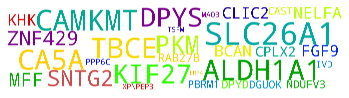

In [48]:
## Save the in-person poster version (higher DPI) 
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../../figures/01.analysis_for_conferences/ashg/word_cloud.png', dpi=600, transparent=True, bbox_inches="tight")
plt.show()

# 2) Graph for number of new genes across different thresholds

In [9]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
chm13_ref = pd.read_csv("../../data/raw/CHM13_merged_aged_loose/bambu_discovery/extended_annotations.gtf",
                        header=None, delimiter="\t", low_memory=False, 
                        names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


chm13_ref = parse_df_columns(chm13_ref, is_ref=False)

In [10]:
mito_names = chm13_ref.loc[chm13_ref["chr"]=="chrM"]['gene_id']

In [11]:
loose_gene_counts = pd.read_csv("../../data/raw/CHM13_merged_aged_loose/bambu_discovery/counts_gene.txt", sep="\t")
stringent_gene_counts = pd.read_csv("../../data/raw/CHM13_merged_aged_stringent/bambu_discovery/counts_gene.txt", sep="\t")

In [12]:
loose_gene_counts = fix_column_names(loose_gene_counts, is_gene=True)
stringent_gene_counts = fix_column_names(stringent_gene_counts, is_gene=True)

In [13]:
## Calculate total counts
loose_gene_counts["total_counts"] = loose_gene_counts[loose_gene_counts.columns[2:6].tolist()].sum(axis=1)
stringent_gene_counts["total_counts"] = stringent_gene_counts[stringent_gene_counts.columns[2:6].tolist()].sum(axis=1)

In [14]:
loose_gene_counts = calculate_cpm(loose_gene_counts, is_gene=True)
loose_gene_counts = loose_gene_counts[loose_gene_counts.columns.drop(list(loose_gene_counts.filter(regex='counts')))]

stringent_gene_counts = calculate_cpm(stringent_gene_counts, is_gene=True)
stringent_gene_counts = stringent_gene_counts[stringent_gene_counts.columns.drop(list(stringent_gene_counts.filter(regex='counts')))]

In [15]:
loose_gene_counts = loose_gene_counts.loc[loose_gene_counts["gene_id"].str.startswith("gene")].copy()
stringent_gene_counts = stringent_gene_counts.loc[stringent_gene_counts["gene_id"].str.startswith("gene")].copy()

In [16]:
loose_gene_counts = loose_gene_counts.loc[~loose_gene_counts["gene_id"].isin(mito_names)]
stringent_gene_counts = stringent_gene_counts.loc[~stringent_gene_counts["gene_id"].isin(mito_names)]

In [17]:
loose_gene_counts_none = loose_gene_counts.copy()
loose_gene_counts_background = loose_gene_counts.loc[loose_gene_counts["total_CPM"] > 0.1].copy()
loose_gene_counts_high_confidence = loose_gene_counts.loc[loose_gene_counts["total_CPM"] > 1].copy()
loose_gene_counts_high_expression = loose_gene_counts.loc[loose_gene_counts["total_CPM"] > 5].copy()

stringent_gene_counts_none = stringent_gene_counts.copy()
stringent_gene_counts_background = stringent_gene_counts.loc[stringent_gene_counts["total_CPM"] > 0.1].copy()
stringent_gene_counts_high_confidence = stringent_gene_counts.loc[stringent_gene_counts["total_CPM"] > 1].copy()
stringent_gene_counts_high_expression = stringent_gene_counts.loc[stringent_gene_counts["total_CPM"] > 5].copy()

In [18]:
loose_gene_counts_none["Label"] = "NDR=1"
loose_gene_counts_background["Label"] = "NDR=1, CPM > 0.1"
loose_gene_counts_high_confidence["Label"] = "NDR=1, CPM > 1"
loose_gene_counts_high_expression["Label"] = "NDR=1, CPM > 5"

stringent_gene_counts_none["Label"] = "NDR=0.1"
stringent_gene_counts_background["Label"] = "NDR=0.1, CPM > 0.1"
stringent_gene_counts_high_confidence["Label"] = "NDR=0.1, CPM > 1"
stringent_gene_counts_high_expression["Label"] = "NDR=0.1, CPM > 5"

In [19]:
print(loose_gene_counts_none.shape[0])
print(loose_gene_counts_background.shape[0])
print(loose_gene_counts_high_confidence.shape[0])
print(loose_gene_counts_high_expression.shape[0])

print(stringent_gene_counts_none.shape[0])
print(stringent_gene_counts_background.shape[0])
print(stringent_gene_counts_high_confidence.shape[0])
print(stringent_gene_counts_high_expression.shape[0])

42996
21973
3039
323
152
146
68
18


In [20]:
df_concat_high = pd.concat([loose_gene_counts_none, loose_gene_counts_background, loose_gene_counts_high_confidence])

df_concat_low =  pd.concat([loose_gene_counts_high_expression, stringent_gene_counts_none, stringent_gene_counts_background,
                      stringent_gene_counts_high_confidence, stringent_gene_counts_high_expression])

In [21]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 20})
rcParams['axes.linewidth'] = 6

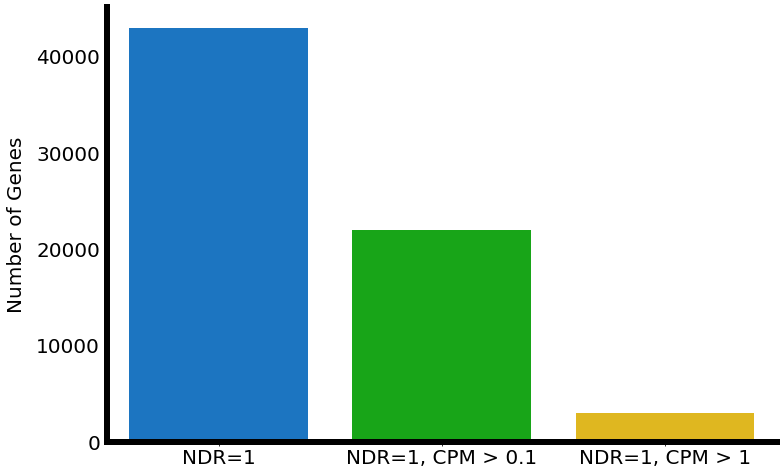

In [22]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

sns.countplot(x="Label", data=df_concat_high, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes", labelpad=10)
plt.xlabel("", labelpad=4)
sns.despine(right=True, left=False, top=True, bottom=False)

plt.savefig('../../figures/01.analysis_for_conferences/ashg/novel_genes_ours_high.png', dpi=300, transparent=True,
            bbox_inches="tight")
plt.show()

In [27]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,8
rcParams.update({'font.size': 20})
rcParams['axes.linewidth'] = 6

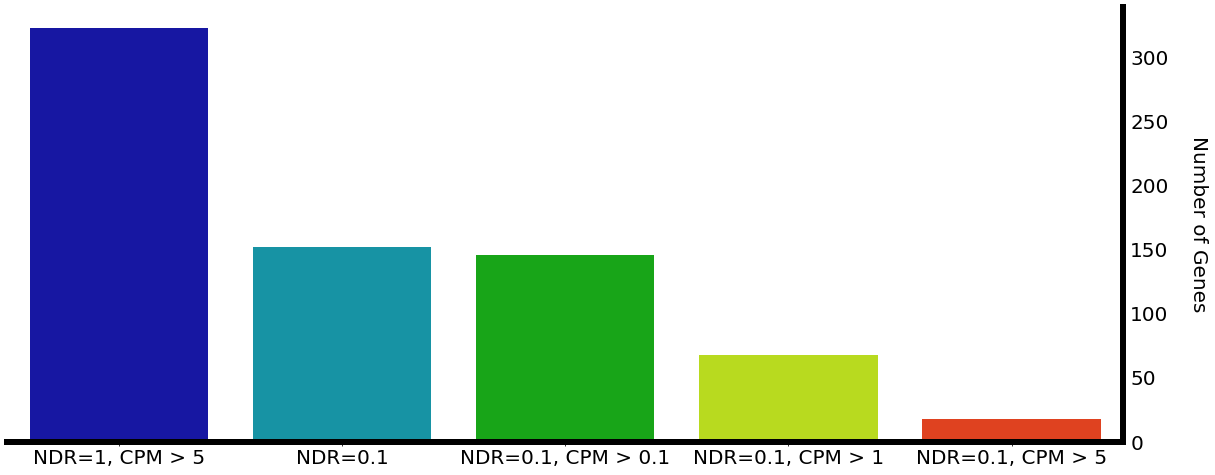

In [36]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("right")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")


sns.countplot(x="Label", data=df_concat_low, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes", labelpad=40, rotation=270)
plt.xlabel("", labelpad=4)
sns.despine(right=False, left=True, top=True, bottom=False)

plt.savefig('../../figures/01.analysis_for_conferences/ashg/novel_genes_ours_low.png', dpi=300, transparent=True,
            bbox_inches="tight")
plt.show()

# 3) Number of CHM13 paralogs and new genes expressed

### Simple two bars bar graph

In [37]:
chm13_counts = pd.read_csv("../../data/raw/CHM13_merged_aged_stringent/bambu_discovery/counts_gene.txt", sep="\t")

In [38]:
chm13_counts = fix_column_names(chm13_counts, is_gene=True)

In [39]:
## Calculate total counts
chm13_counts["total_counts"] = chm13_counts[chm13_counts.columns[2:6].tolist()].sum(axis=1)

In [40]:
chm13_counts = calculate_cpm(chm13_counts, is_gene=True)

chm13_counts = chm13_counts[chm13_counts.columns.drop(list(chm13_counts.filter(regex='counts')))]

In [41]:
chm13_counts.head()

,gene_id,cshl_1304_uky_CPM,cshl_356_uky_CPM,cshl_1271_uky_CPM,cshl_1291_uky_CPM,total_CPM
0,CHM13_G0002360,0.00,0.03,0.00,0.00,0.01
1,CHM13_G0002906,1.20,1.85,0.72,0.65,1.05
2,CHM13_G0003812,0.29,0.53,0.15,0.26,0.30
3,CHM13_G0006285,4.68,2.51,3.43,5.00,3.62
4,CHM13_G0007830,0.00,0.00,0.00,0.00,0.00


In [42]:
paralogs = chm13_counts.loc[chm13_counts["gene_id"].str.contains("(", regex=False)].copy()
chm13_new = chm13_counts.loc[chm13_counts["gene_id"].str.startswith("CHM13")].copy()

In [43]:
paralogs_filtered = paralogs.loc[paralogs["total_CPM"] > 1].copy()
chm13_new_filtered = chm13_new.loc[chm13_new["total_CPM"] > 1].copy()

In [44]:
paralogs_filtered["Label"] = "CHM13 New Paralogs"

In [45]:
chm13_new_filtered["Label"] = "CHM13 New Genes"

In [46]:
df_chm13_new = pd.concat([chm13_new_filtered, paralogs_filtered])

In [47]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,8
rcParams.update({'font.size': 20})
rcParams['axes.linewidth'] = 6

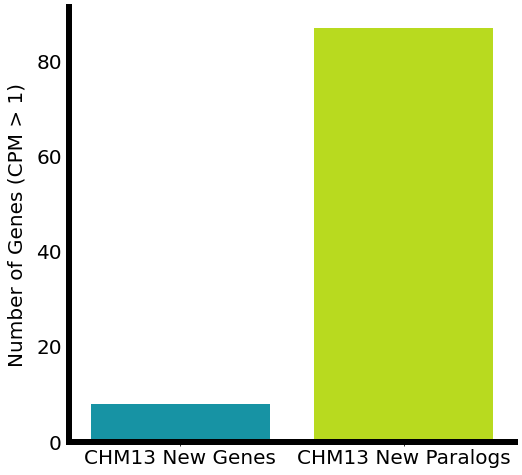

In [48]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")

sns.countplot(x="Label", data=df_chm13_new, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes (CPM > 1)", labelpad=10)
plt.xlabel("", labelpad=4)
sns.despine(right=True, left=False, top=True, bottom=False)

plt.savefig('../../figures/01.analysis_for_conferences/ashg/novel_genes_chm13.png', dpi=300, transparent=True,
            bbox_inches="tight")
plt.show()